In [1]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [4]:
  slides_path = '/gdrive/MyDrive/slides'
  assert os.path.exists(slides_path)

In [5]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [38]:
# Improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

In [39]:
class Slide:
  default_x, default_y, default_width, default_height = 0, 0, None, None
  def __init__(self, id, level = 4):
    self.id = id
    self.level = level
    self.wsi_path = os.path.join(slides_path, 'tumor_' + id + '.tif')
    self.tumor_mask_path = os.path.join(slides_path, 'tumor_' + id + '_mask.tif')

    self.wsi = open_slide(self.wsi_path)
    print ("Read WSI from %s with width: %d, height: %d" % (self.wsi_path, 
                                                        self.wsi.level_dimensions[0][0], 
                                                        self.wsi.level_dimensions[0][1]))
    
    self.tumor_mask = open_slide(self.tumor_mask_path)
    print ("Read tumor mask from %s" % (self.tumor_mask_path))

    level_count = len(self.wsi.level_dimensions)
    print("Slide includes %d levels", level_count)
    for i in range(level_count - 1):
        print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                                self.wsi.level_dimensions[i], 
                                                                self.wsi.level_downsamples[i]))
        # Make sure the dimensions of mask and slide match.
        assert self.tumor_mask.level_dimensions[i][0] == self.wsi.level_dimensions[i][0]
        assert self.tumor_mask.level_dimensions[i][1] == self.wsi.level_dimensions[i][1]

    # Verify downsampling works as expected
    maximum_level = level_count - 1;
    width, height = self.wsi.level_dimensions[maximum_level]
    assert width * self.wsi.level_downsamples[maximum_level] == self.wsi.level_dimensions[0][0]
    assert height * self.wsi.level_downsamples[maximum_level] == self.wsi.level_dimensions[0][1]
  
  def get_wsi_image(self, show=False, x=default_x, y=default_y, level=None, width=default_width, height=default_height, tissue=False):
    level = level if level else self.level
    width = width if width else self.wsi.level_dimensions[level][0]
    height = height if height else self.wsi.level_dimensions[level][1]
    image = read_slide(self.wsi, x=x, y=y, level=level, width=width, height=height)
    if tissue:
      tissue_pixels = find_tissue_pixels(image)
      percent_tissue = len(tissue_pixels) / float(image.shape[0] * image.shape[0]) * 100
      print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 
      image = apply_mask(image, tissue_pixels)
    if show:
      plt.figure(figsize=(10,10), dpi=100)
      plt.imshow(image)
    else:
      return image

  def get_mask_image(self, show=False, x=default_x, y=default_y, level=None, width=default_width, height=default_height):
    level = level if level else self.level
    width = width if width else self.wsi.level_dimensions[level][0]
    height = height if height else self.wsi.level_dimensions[level][1]
    # The program provided by the dataset authors generates a mask with R,G,B channels.
    # The mask info we need is in the first channel only.
    # If skip this step, the mask will be displayed as all black.
    image = read_slide(self.tumor_mask, x=x, y=y, level=level, width=width, height=height)[:,:,0]
    if show:
      plt.figure(figsize=(10,10), dpi=100)
      plt.imshow(image)
    else:
      return image
  
  def show_overlay(self, x=default_x, y=default_y, level=None, width=default_width, height=default_height, alpha=0.5):
    level = level if level else self.level
    plt.figure(figsize=(10,10), dpi=100)
    plt.imshow(self.get_wsi_image(x, y, level, width, height))
    plt.imshow(self.get_mask_image(x, y, level, width, height), cmap='jet', alpha=alpha) # Red regions contains cancer.

  def get_region_image(self, show=False, type='mask', x=0, y = 0, level=None, width=50, height=50):
    # extract a region from the downsampled image
    # Notice we're multiplying the x,y coordinates by the downsample factor.
    level = level if level else self.level
    downsample_factor = 2**level
    if type == 'mask':
      region_image = self.get_mask_image(x=x * downsample_factor, y=y * downsample_factor, level=level, width=width, height=width)
    else:
      region_image = self.get_wsi_image(x=x * downsample_factor, y=y * downsample_factor, level=level, width=width, height=width)
    if show:
      plt.imshow(region_image)
    else:
      return region_image


slide = Slide(id='091', level=7)

Read WSI from /gdrive/MyDrive/slides/tumor_091.tif with width: 61440, height: 53760
Read tumor mask from /gdrive/MyDrive/slides/tumor_091_mask.tif
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64


62589 tissue_pixels pixels (35.5 percent of the image)


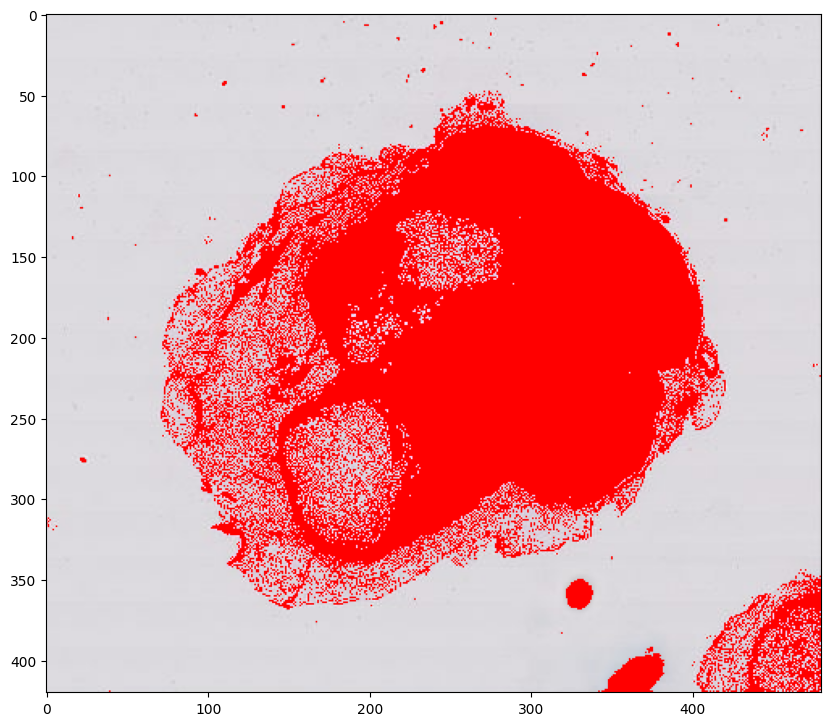

In [41]:
slide.get_wsi_image(show=True, tissue=True)

In [ ]:
slide.get_mask_image(show=True)

In [ ]:
slide.show_overlay()

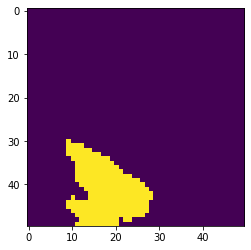

In [37]:
slide.get_region_image(show=True, x=350, y=120, level=7)